In [1]:
# grab the TF_EVENTS_PARENT_DIR from the .env file
import os
from dotenv import load_dotenv
from pathlib import Path
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import re
from matplotlib import pyplot as plt
from typing import Callable

2025-11-05 18:24:31.461619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 18:24:31.494159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 18:24:32.064626: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
make_titles = True
def plt_title(title: str):
    if make_titles:
        plt.title(title)

In [3]:
load_dotenv()
TF_EVENTS_PARENT_DIR = Path(os.getenv("TF_EVENTS_PARENT_DIR"))  # type: ignore
TF_EVENTS_PARENT_DIR

PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs')

In [4]:
training_folders = [d for d in TF_EVENTS_PARENT_DIR.iterdir() if d.is_dir()]
training_folders.sort()

# grab "events.out.tfevents.*" file from each training folder
training_events = [list(training.glob("**/events.out.tfevents.*"))[0] for training in training_folders]
training_events

[PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs/gaitnet_20251013_105702-e351062c-dist-curr/events.out.tfevents.1760367422.pop-os.9289.0'),
 PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs/gaitnet_20251013_232112-e351062c-cont/events.out.tfevents.1760412072.pop-os.8368.0'),
 PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs/gaitnet_20251014_230314-e351062c-cont/events.out.tfevents.1760497394.pop-os.8557.0'),
 PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs/gaitnet_20251023_150538-00000000-no-curr/events.out.tfevents.1761246338.pop-os.599934.0'),
 PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs/gaitnet_20251024_081058-6f5e92ae-survival-curr/events.out.tfevents.1761307858.pop-os.1173885.0'),
 PosixPath('/home/owen/Documents/repos/greedy-dynamic-quadruped-gait/training/gaitnet/runs/ga

In [5]:
experiments: dict[str, list[Path]] = {}
prev_experiment = ""

for event_file in training_events:
    experiment_name = event_file.parent.name
    if "cont" in experiment_name:
        experiments[prev_experiment].append(event_file)
    else:
        experiments[experiment_name] = [event_file]
        prev_experiment = experiment_name

list(experiments.keys())

['gaitnet_20251013_105702-e351062c-dist-curr',
 'gaitnet_20251023_150538-00000000-no-curr',
 'gaitnet_20251024_081058-6f5e92ae-survival-curr',
 'gaitnet_20251025_221009-6f5e92ae-survival-curr',
 'gaitnet_20251027_211945-e351062c-dist-curr',
 'gaitnet_20251029_212018-6f5e92ae-survival-curr',
 'gaitnet_20251101_012343-c01ed84-footstep-cost',
 'gaitnet_20251103_214457-6f60107-swing-duration']

In [6]:
# list all tags in a single experiment
event_file = training_events[0]
tags = set()
for e in summary_iterator(str(event_file)):
    for v in e.summary.value:
        tags.add(v.tag)
list(tags)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


['Custom_Metrics/leg_option_std',
 'Loss/entropy',
 'Episode_Termination/terrain_out_of_bounds',
 'Perf/total_fps',
 'Episode_Reward/flat_orientation_l2',
 'Episode_Termination/foot_below_ground',
 'Episode_Reward/a_foot_in_swing',
 'Train/mean_reward',
 'Episode_Reward/op_penalty',
 'Metrics/base_velocity/error_vel_xy',
 'Custom_Metrics/logit_cost_correlation',
 'Loss/value_function',
 'Episode_Reward/no_op',
 'Episode_Reward/terminating',
 'Custom_Metrics/duration_std',
 'Curriculum/terrain_levels',
 'Custom_Metrics/ops_per_step',
 'Loss/surrogate',
 'Episode_Termination/bad_orientation',
 'Train/mean_episode_length/time',
 'Episode_Reward/alive',
 'Episode_Termination/bad_height',
 'Episode_Reward/joint_accelerations',
 'Episode_Reward/xy_tracking',
 'Perf/learning_time',
 'Train/mean_episode_length',
 'Episode_Termination/time_out',
 'Episode_Reward/lin_vel_z_l2',
 'Metrics/base_velocity/error_vel_yaw',
 'Custom_Metrics/duration_mean',
 'Loss/learning_rate',
 'Perf/collection time'

In [7]:
def plot_experiment(
    experiments: dict[str, list[Path]],
    tag: str,
    experiment_regex: str = ".*",
    value_transform: Callable[[float, float], float] = lambda step, val: val,
) -> None:
    experiments_to_plot = [
        exp for exp in experiments if re.match(experiment_regex, exp)
    ]

    plt.figure(figsize=(6, 4))

    color_index = 0

    for experiment_name in experiments_to_plot:
        color = f"C{color_index % 10}"
        event_files = experiments[experiment_name]
        for event_file in event_files:
            steps = []
            values = []
            for e in summary_iterator(str(event_file)):
                for v in e.summary.value:
                    if v.tag == tag:
                        steps.append(e.step)
                        values.append(value_transform(e.step, v.simple_value))
            plt.plot(
                steps,
                values,
                color=color,
                label=experiment_name if event_file == event_files[0] else "",
            )
        color_index += 1

    plt.xlabel("Training Step")

In [8]:
# make sure images dir exists
images_dir = Path.cwd() / "images"
images_dir.mkdir(exist_ok=True)

In [9]:
def save_fig(filename: str) -> None:
    plt.savefig(images_dir / filename, dpi=300, bbox_inches='tight', pad_inches=0.3)

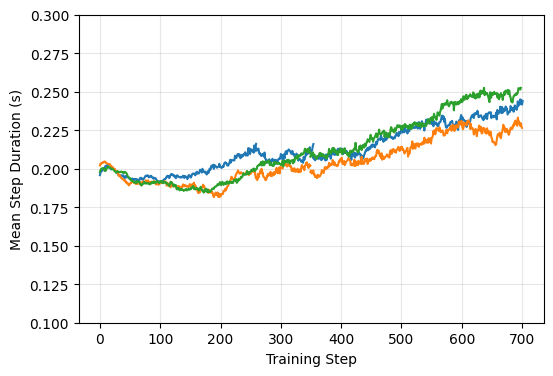

In [10]:
plot_experiment(
    experiments, 
    "Custom_Metrics/duration_mean", 
    r".*?survival-curr",
)

plt_title(f"Duration Mean during Training")
plt.ylabel("Mean Step Duration (s)")
plt.ylim(0.1, 0.3)
plt.grid(alpha=0.3)

save_fig('duration_mean_survival-curr.png')
plt.show()

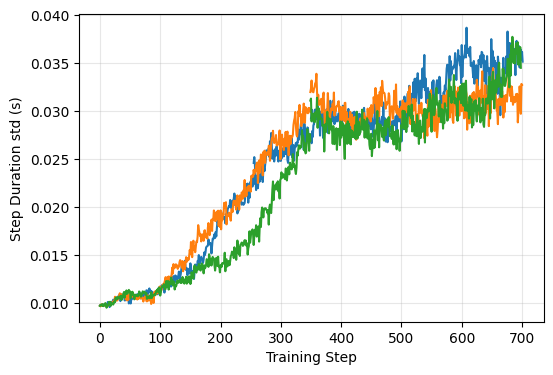

In [11]:
plot_experiment(
    experiments, 
    "Custom_Metrics/duration_std", 
    r".*?survival-curr",
)

plt_title(f"Step Duration std during Training")
plt.ylabel("Step Duration std (s)")
plt.grid(alpha=0.3)

save_fig('duration_std_survival-curr.png')
plt.show()

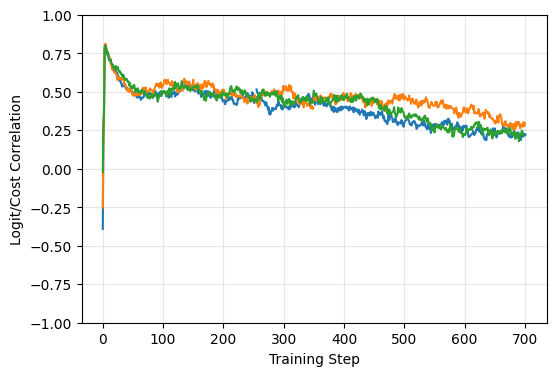

In [12]:
plot_experiment(
    experiments, 
    "Custom_Metrics/logit_cost_correlation", 
    r".*?survival-curr",
)

plt_title(f"Logit/Cost Correlation during Training")
plt.ylabel("Logit/Cost Correlation")
plt.ylim(-1, 1)
plt.grid(alpha=0.3)

save_fig('logit_cost_correlation_survival-curr.png')
plt.show()

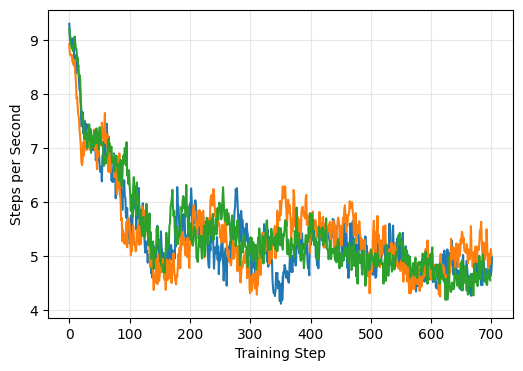

In [13]:
model_freq = 25
plot_experiment(
    experiments, 
    "Custom_Metrics/ops_per_step", 
    r".*?survival-curr",
    value_transform=lambda step, val: model_freq * val,
)

plt_title(f"Steps per Second during Training")
plt.ylabel("Steps per Second")
# plt.ylim(-1, 1)
plt.grid(alpha=0.3)

save_fig('steps_per_second_survival-curr.png')
plt.show()

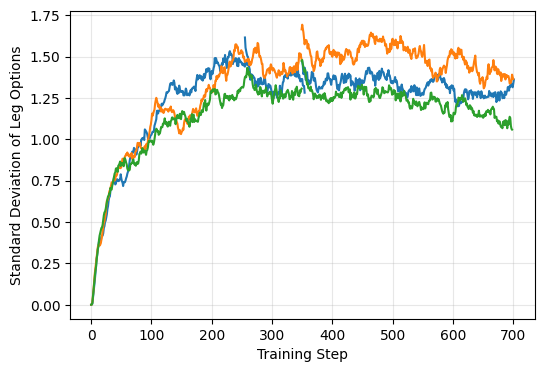

In [14]:
plot_experiment(
    experiments, 
    "Custom_Metrics/leg_option_std", 
    r".*?survival-curr",
)

plt_title(f"Standard Deviation of Leg Options during Training")
plt.ylabel("Standard Deviation of Leg Options")
# plt.ylim(-1, 1)
plt.grid(alpha=0.3)

save_fig('standard_deviation_of_leg_options_survival-curr.png')
plt.show()

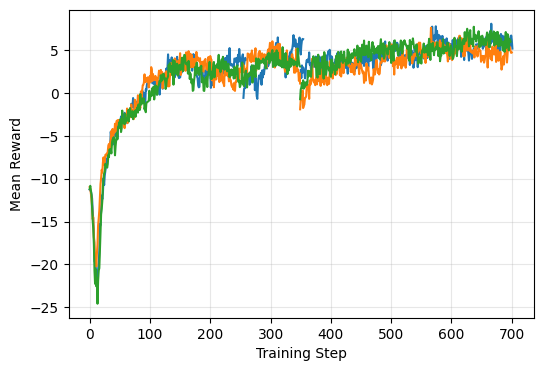

In [15]:
plot_experiment(
    experiments, 
    "Train/mean_reward", 
    r".*?survival-curr",
)

plt_title(f"Mean Reward during Training")
plt.ylabel("Mean Reward")
# plt.ylim(-1, 1)
plt.grid(alpha=0.3)

save_fig('mean_reward_survival-curr.png')
plt.show()

In [16]:
def contrast_plot_experiment(
    experiments: dict[str, list[Path]],
    tag: str,
    experiment_regex: str = ".*",
    value_transform: Callable[[float, float], float] = lambda step, val: val,
    base_experiment: str = "survival-curr",
    base_experiment_alpha: float = 0.6,
) -> None:
    experiments_to_plot = [
        exp for exp in experiments if re.match(experiment_regex, exp)
    ]

    plt.figure(figsize=(6, 4))

    color_index = 0

    for experiment_name in experiments_to_plot:
        color = "C1" if base_experiment not in experiment_name else "C0"
        event_files = experiments[experiment_name]
        for event_file in event_files:
            steps = []
            values = []
            for e in summary_iterator(str(event_file)):
                for v in e.summary.value:
                    if v.tag == tag:
                        steps.append(e.step)
                        values.append(value_transform(e.step, v.simple_value))
            plt.plot(
                steps,
                values,
                color=color,
                alpha=base_experiment_alpha if base_experiment in experiment_name else 1.0,
                label=experiment_name if event_file == event_files[0] else "",
            )
        color_index += 1

    plt.xlabel("Training Step")

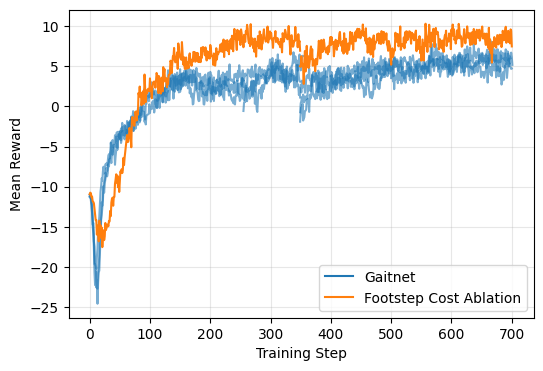

In [17]:
contrast_plot_experiment(
    experiments,
    "Train/mean_reward",
    r".*?(?:survival-curr|footstep-cost)",
)

plt_title(f"Mean Reward during Training")
plt.ylabel("Mean Reward")
# manually set legend labels and colors, one for survival-curr and one for footstep-cost
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", label="Gaitnet"),
        plt.Line2D([0], [0], color="C1", label="Footstep Cost Ablation"),
    ],
    loc="lower right"
)

plt.grid(alpha=0.3)

save_fig('mean_reward_survival-curr_vs_footstep-cost.png')
plt.show()

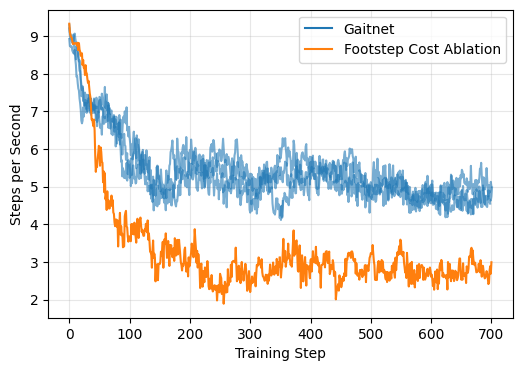

In [ ]:
model_freq = 25
contrast_plot_experiment(
    experiments, 
    "Custom_Metrics/ops_per_step", 
    r".*?(?:survival-curr|footstep-cost)",
    value_transform=lambda step, val: model_freq * val,
)

plt_title(f"Steps per Second during Training")
plt.ylabel("Steps per Second")
# manually set legend labels and colors, one for survival-curr and one for footstep-cost
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", label="Gaitnet"),
        plt.Line2D([0], [0], color="C1", label="Footstep Cost Ablation"),
    ],
    loc="upper right"
)

plt.grid(alpha=0.3)

save_fig('steps_per_second_survival-curr_vs_footstep-cost.png')
plt.show()

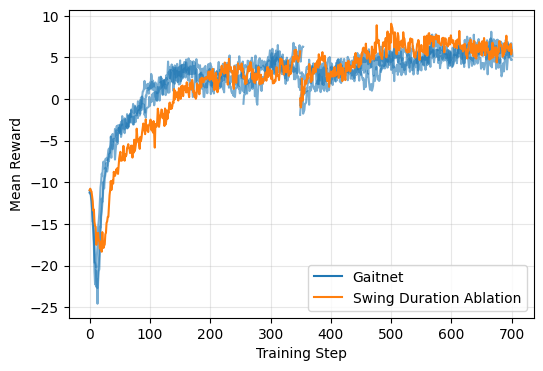

In [18]:
contrast_plot_experiment(
    experiments,
    "Train/mean_reward",
    r".*?(?:survival-curr|swing-duration)",
)

plt_title(f"Mean Reward during Training")
plt.ylabel("Mean Reward")
# manually set legend labels and colors, one for survival-curr and one for swing-duration
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", label="Gaitnet"),
        plt.Line2D([0], [0], color="C1", label="Swing Duration Ablation"),
    ],
    loc="lower right"
)

plt.grid(alpha=0.3)

save_fig('mean_reward_survival-curr_vs_swing-duration.png')
plt.show()